In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
def calculate_quartiles_and_iqr(values):
    """
    Calculate the first quartile (Q1), third quartile (Q3), and the interquartile range (IQR)
    for a given numeric dataset.

    The interquartile range is a measure of statistical dispersion and is defined as:
        IQR = Q3 - Q1

    This function is commonly used for:
    - Outlier detection (e.g., using 1.5×IQR rule)
    - Summarizing the spread of non-normally distributed data
    - Robust descriptive statistics unaffected by extreme values

    Parameters
    ----------
    values : array-like (list, np.ndarray, or pd.Series)
        A 1D array of numerical values. Must not contain NaNs or missing entries.

    Returns
    -------
    tuple of floats
        - Q1 (25th percentile)
        - Q3 (75th percentile)
        - IQR (Q3 - Q1)

    Example
    -------
    >>> data = [10, 15, 18, 21, 30, 42, 55]
    >>> q1, q3, iqr = calculate_quartiles_and_iqr(data)
    >>> print(f"Q1={q1}, Q3={q3}, IQR={iqr}")

    Notes
    -----
    - Uses NumPy's `percentile()` function with default linear interpolation.
    - If input contains NaNs, use `np.nanpercentile()` instead.
    """

    # Compute the 25th percentile (first quartile)
    q1 = np.percentile(values, 25)

    # Compute the 75th percentile (third quartile)
    q3 = np.percentile(values, 75)

    # Interquartile range is the spread between Q3 and Q1
    iqr = q3 - q1

    return q1, q3, iqr

In [5]:
def evaluate_anomaly_detection_iqr(
    all_files: List[str],
    path: str,
    anomaly_type: int = 2,
    k_range: Tuple[float, float, float] = (0.5, 4.0, 0.5)
) -> pd.DataFrame:
    """
    Evaluate anomaly detection using IQR thresholding on modified time series data.

    For each file, the function:
    - Loads the data (expects 'modified' and 'labels' columns),
    - Scales the series using StandardScaler,
    - Computes Q1, Q3, and IQR on the scaled data,
    - Iteratively evaluates different IQR thresholds to maximize F1-score,
    - Stores and returns the best F1, precision, and recall scores per building.

    Parameters
    ----------
    all_files : List[str]
        List of CSV filenames (one per building) to evaluate.
    path : str
        Directory path where the files are located.
    anomaly_type : int, default 2
        The label value considered anomalous. Others are treated as normal (0).
    k_range : Tuple[float, float, float], default (0.5, 4.0, 0.5)
        Start, stop, and step size for the IQR multiplier K.

    Returns
    -------
    pd.DataFrame
        DataFrame with per-building metrics: F1-score, precision, and recall.

    Example
    -------
    >>> df_scores = evaluate_anomaly_detection_iqr(all_files, "OUTPUT/MODIFIED", anomaly_type=2)
    >>> print(df_scores.head())

    Notes
    -----
    - This method does NOT perform imputation or handle missing values beyond dropping them.
    - It assumes 'modified' is a numeric feature and 'labels' contains ground-truth anomaly labels.
    """
    results = []

    for file in tqdm(all_files, desc="Evaluating anomaly detection"):
        # Load building data
        building = pd.read_csv(os.path.join(path, file))
        X = building['modified']
        y = np.where(building['labels'].values == anomaly_type, 1, 0)

        # Drop NaNs if any (imputation is left to upstream)
        X = pd.DataFrame(X).dropna()
        y = y[:len(X)]  # align labels

        # Scale the feature
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Compute IQR components
        q1, q3, iqr = calculate_quartiles_and_iqr(X_scaled)

        # Search for best K (IQR multiplier)
        best_f1 = 0
        best_prec = 0
        best_rec = 0

        for K in np.arange(*k_range):
            low, high = q1 - K * iqr, q3 + K * iqr
            y_pred = np.where((X_scaled < low) | (X_scaled > high), 1, 0)

            f1 = f1_score(y, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_prec = precision_score(y, y_pred)
                best_rec = recall_score(y, y_pred)

        building_id = int(file.split("_")[0])
        results.append({
            "building_id": building_id,
            "F1_score": best_f1,
            "Precision": best_prec,
            "Recall": best_rec
        })

    score_df = pd.DataFrame(results).sort_values("building_id").reset_index(drop=True)
    print("\n=== Overall Performance Summary ===")
    print(score_df.describe().loc[["mean", "std", "min", "max"]])

    return score_df


In [11]:
# Define your configuration
path = "/data1/home/nitinvetcha/Ashwin_KM_Code/tsfm_learning/Anomaly_Injection_IISc/injection_code/src/OUTPUT_BDG2/MODIFIED/TYPE4"
injected_files = [f for f in os.listdir(path) if f.endswith(".csv")]
anomaly_type = 4

# Run evaluation
score_df = evaluate_anomaly_detection_iqr(
    all_files=injected_files,
    path=path,
    anomaly_type=anomaly_type,
    k_range=(0.5, 4.5, 0.5)  # optional: adjust this range as needed
)

# View and optionally save the result
print(score_df.head())
score_df.to_csv(f"bdg2_iqr_statistics/iqr_evaluation_type_{anomaly_type}.csv", index=False)

Evaluating anomaly detection: 100%|██████████| 1553/1553 [01:49<00:00, 14.18it/s]


=== Overall Performance Summary ===
      building_id  F1_score  Precision    Recall
mean   791.249839  0.554051   0.773902  0.474923
std    456.046328  0.199831   0.256585  0.189163
min      1.000000  0.065344   0.038374  0.092834
max   1578.000000  0.980048   1.000000  1.000000
   building_id  F1_score  Precision    Recall
0            1  0.517007   0.850746  0.371336
1            2  0.623318   1.000000  0.452769
2            3  0.767045   0.978261  0.630841
3            4  0.473563   0.622356  0.382189
4            5  0.580791   0.948339  0.418567


In [12]:
# Median of F1 scores
median_f1 = score_df['F1_score'].median()
print(f"Median F1 score across all buildings: {median_f1:.4f}")
median_recall = score_df['Recall'].median()
print(f"Median Recall across all buildings: {median_recall:.4f}")
# Median Precision
median_precision = score_df['Precision'].median()
print(f"Median Precision across all buildings: {median_precision:.4f}")

Median F1 score across all buildings: 0.5831
Median Recall across all buildings: 0.4511
Median Precision across all buildings: 0.8678


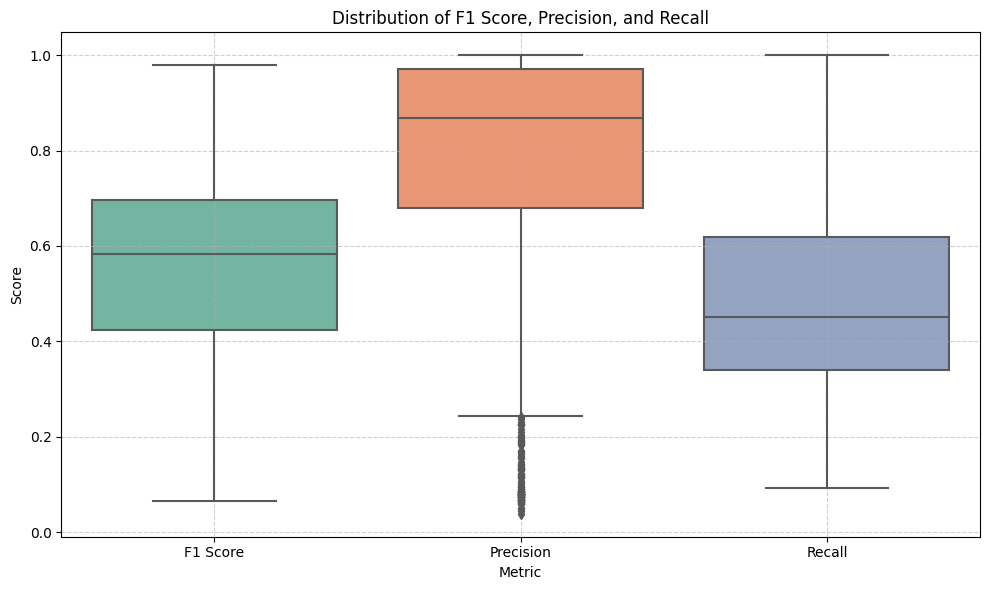

In [13]:
f1_scores = score_df['F1_score']
recall_scores = score_df['Recall']
precision_scores = score_df['Precision']
# Plotting the scores
# Prepare a DataFrame for boxplotting
import seaborn as sns

data = pd.DataFrame({
    "F1 Score": f1_scores,
    "Precision": precision_scores,
    "Recall": recall_scores
})

# Melt the DataFrame for seaborn
data_melted = data.melt(var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_melted, x="Metric", y="Score", palette="Set2")
plt.title("Distribution of F1 Score, Precision, and Recall")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"bdg2_iqr_plots/anomaly_detection_boxplots_for_type_{anomaly_type}.png")
plt.show()